# Clustering Schoolwork——Markov Cluster Algorithm on Iris Dataset
### milestone 1 
#### author：Hsu An      2016011434
#### last update: 20 Nov 2018


基本思路：
1. 使用欧式距离度量计算每个样本之间的相似度，求出矩阵（概率矩阵）
2. 卡阈值，剔除距离过大的值（去掉边）
3. 将剔除过大的值后将矩阵转化为无向图
4. normalize矩阵，并进行迭代（Expansion，Inflation）
5. 当矩阵趋于稳定时，将结果转化为聚簇

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from pandas.tools.plotting import radviz

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import sklearn.preprocessing

from scipy.sparse import isspmatrix, dok_matrix, csc_matrix

from sklearn.metrics import accuracy_score

In [2]:
# 导入iris数据集


iris = load_iris()  # 加载数据集

features = iris.data # 获取属性数据(各种特征值)
labels = iris.target # 获取类别数据（花的分类）
target_names = iris.target_names # 获取数据的分类名称（花的分类名称）

In [3]:
# # 使用Radviz图将数据可视化  (暂时无效，待使用)
# features_df = pd.DataFrame(features)
# # features_df.columns = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
# labels_df = pd.DataFrame(labels)
# labels_df.columns = ['class']

# radviz(features_df, labels_df)


[]

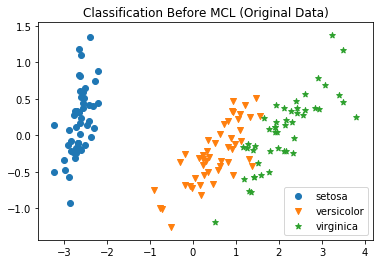

In [4]:
# 使用PCA降维并进行可视化
pca = PCA(n_components=2)
pca.fit(features)
features_new = pca.transform(features)
# plt.figure(figsize=[5,5],dpi=200)
features_new_1 = plt.scatter(features_new[0:50, 0], features_new[0:50, 1],marker='o')
features_new_2 = plt.scatter(features_new[51:100, 0], features_new[51:100, 1],marker='v')
features_new_3 = plt.scatter(features_new[101:149, 0], features_new[101:149, 1],marker='*')
plt.legend(handles=[features_new_1, features_new_2,features_new_3], labels=['setosa', 'versicolor', 'virginica'],  loc='best')
plt.title('Classification Before MCL (Original Data)')
plt.plot()

In [5]:
# 求相似度矩阵
simple_size = 150 # simple_size定义样本的数量
sim_arr = [] # sim_arr定义相似度列表
for i in features:
    for j in features:
        distance = np.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2+(i[2]-j[2])**2+(i[3]-j[3])**2)  # 求出每个样本点之间的欧式距离
        sim_arr.append(float(distance))  # 将欧式距离转化为float类型,并添加到list中
sim_arr = np.array(sim_arr) # 将list转化为np.array类型
sim_arr = sim_arr.reshape(simple_size,simple_size) # 将相似度列表转化为150*150的矩阵形式

In [6]:
# 暂定阈值为1，将距离大于1的边全部剔除，小于等于1且不等于1（不加自环）的边设置权重为1（转化为无向图）
threshold = 1.3  # 暂定阈值为1

for i in range(simple_size):
    for j in range(simple_size):
        if sim_arr[i][j] > threshold:
            sim_arr[i][j] = 0
        if sim_arr[i][j] < threshold and sim_arr[i][j] != 0:
            sim_arr[i][j] = 1

In [7]:
# 添加自环
for i in range(simple_size):
    sim_arr[i][i] = 1

In [8]:
# 矩阵标准化
def normalize(matrix):

#     功能：将给定矩阵的行进行标准化
#     输入参数：
#         martix:给定矩阵
#     输出：
#         标准化后的矩阵martix'

    return sklearn.preprocessing.normalize(matrix,norm="l1", axis=0)

In [9]:
# 矩阵相乘操作(Expansion)
def dot_multiply(matrix):
#     功能：将给定矩阵进行乘法
#     输入参数：
#         martix:给定矩阵
#     输出：
#         相乘后的矩阵martix'
    return np.dot(matrix,matrix)

In [10]:
# 矩阵膨胀操作（Inflation）
def inflation(matrix,inflat_factor):
#    功能：将给定矩阵进行膨胀操作(先对矩阵做inflat_factor次乘方，之后标准化矩阵)
#    输入参数：
#         martix:给定矩阵
#         inflat_factor:膨胀算子，将矩阵的每一个元素进行inflat_factor次乘方
#      输出：
#          膨胀后的矩阵martix'
    matrix_inflation = np.power(matrix,inflat_factor) # 将矩阵每个元素进行inflat_factor乘方
    matrix_inflation = normalize(matrix_inflation)  # 将乘方好的矩阵进行标准化处理
    
    return matrix_inflation

In [11]:
# 判断矩阵是否收敛
def matrix_converge(matrix1,matrix2,rtol=1e-05, atol=1e-08):
#    功能：判断矩阵是否收敛
#    输入参数：
#         matrix1:给定矩阵1
#         matrix2:给定矩阵2
#         rtol=1e-05, atol=1e-08：宽容度
#      输出：
#         bool类型，如果收敛，返回true，否则返回false
#          
    return np.allclose(matrix1,matrix2,rtol=rtol, atol=atol)

In [12]:
# 计算带权邻接矩阵
iterate_num = 100 # 指定迭代次数
inflat_factors = 3 # 指定膨胀系数
sim_arr_last = sim_arr  # sim_arr_last表示上一次迭代时的矩阵

sim_arr = normalize(sim_arr) # 将矩阵标准化处理

for i in range(iterate_num): # 进行iterate_num次迭代
    sim_arr = dot_multiply(sim_arr)  # 进行矩阵相乘操作
    sim_arr = inflation(sim_arr,inflat_factor=inflat_factors)  # 进行膨胀操作
    if matrix_converge(sim_arr,sim_arr_last):  # 当迭代到相似度基本一致时（基本收敛），提前停止迭代过程
        print('The iteration processed for '+str(i+1)+' rounds')
        print('Iteration has stopped. The best iteration time is '+str(i+1)+".")
        break
    else:
        sim_arr_last = sim_arr
        print('The iteration processed for '+str(i+1)+' rounds')
print('The Adjacency matrix has been converged.')

The iteration processed for 1 rounds
The iteration processed for 2 rounds
The iteration processed for 3 rounds
The iteration processed for 4 rounds
The iteration processed for 5 rounds
The iteration processed for 6 rounds
The iteration processed for 7 rounds
The iteration processed for 8 rounds
The iteration processed for 9 rounds
The iteration processed for 10 rounds
Iteration has stopped. The best iteration time is 10.
The Adjacency matrix has been converged.


In [13]:
# 将邻接矩阵转化为聚类  best distance = 1.3 inflat_factors = 3  len(cluster_result) = 3   acc = 0.76
def get_clusters(matrix):

    if not isspmatrix(matrix):
        # cast to sparse so that we don't need to handle different 
        # matrix types
        matrix = csc_matrix(matrix)

    # get the attractors - non-zero elements of the matrix diagonal
    attractors = matrix.diagonal().nonzero()[0]

    # somewhere to put the clusters
    clusters = set()

    # the nodes in the same row as each attractor form a cluster
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters))

In [14]:
# 输出聚类结果
cluster_result = get_clusters(sim_arr)
len(cluster_result)
for index,i in enumerate(cluster_result):
    print('Cluster '+str(index+1)+':')
    print(i)

Cluster 1:
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49)
Cluster 2:
(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 108, 110, 111, 112, 113, 114, 115, 116, 119, 120, 121, 123, 124, 126, 127, 128, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149)
Cluster 3:
(102, 105, 107, 109, 117, 118, 120, 122, 125, 129, 130, 131, 135, 143)


In [15]:
# 整理聚类结果
cluster_index_0 = np.array(cluster_result[0])
cluster_index_1 = np.array(cluster_result[1])
cluster_index_2 = np.array(cluster_result[2])

# 元素查重
for index_i,i in enumerate(cluster_index_0):
    for index_j,j in enumerate(cluster_index_1):
        if i == j:
            print('Find same component '+str(i)+' in cluster_0 and cluster_1')
            print('The index in cluster_0 is '+str(index_i))
            print('The index in cluster_1 is '+str(index_j))
    for index_k,k in enumerate(cluster_index_2):
        if i == k:
            print('Find same component '+str(i)+' in cluster_0 and cluster_2')
            print('The index in cluster_1 is '+str(index_i))
            print('The index in cluster_2 is '+str(index_k))
for index_i,i in enumerate(cluster_index_1):
    for index_j,j in enumerate(cluster_index_2):
        if i == j:
            print('Find same component '+str(i)+' in cluster_1 and cluster_2')
            print('The index in cluster_1 is '+str(index_i))
            print('The index in cluster_2 is '+str(index_j))

Find same component 120 in cluster_1 and cluster_2
The index in cluster_1 is 64
The index in cluster_2 is 6


In [16]:
# 剔除重复元素
cluster_index_1 = np.delete(cluster_index_1,64)

In [17]:
# 聚类后标签列表
cluster_lable = np.zeros(150) # 初始化标签列表,全部置为0

for i in cluster_index_0:
    cluster_lable[i] = 0
for i in cluster_index_1:
    cluster_lable[i] = 1
for i in cluster_index_2:
    cluster_lable[i] = 2    

[]

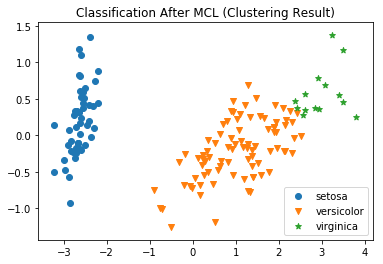

In [18]:
# 使用PCA降维并将聚类结果进行可视化

# 初始化聚类数据坐标列表
cluster_data_0 = np.zeros(shape=(len(cluster_index_0),2))
cluster_data_1 = np.zeros(shape=(len(cluster_index_1),2))
cluster_data_2 = np.zeros(shape=(len(cluster_index_2),2))

# 将聚类结果的坐标添加到列表中
for index,i in enumerate(cluster_index_0):
    cluster_data_0[index] = features_new[i]
for index,i in enumerate(cluster_index_1):
    cluster_data_1[index] = features_new[i]
for index,i in enumerate(cluster_index_2):
    cluster_data_2[index] = features_new[i]

# 绘制图像
# plt.figure(figsize=[5,5],dpi=200)
features_new_1 = plt.scatter(cluster_data_0[:, 0], cluster_data_0[:, 1],marker='o')
features_new_2 = plt.scatter(cluster_data_1[:, 0], cluster_data_1[:, 1],marker='v')
features_new_3 = plt.scatter(cluster_data_2[:, 0], cluster_data_2[:, 1],marker='*')
plt.legend(handles=[features_new_1, features_new_2,features_new_3], labels=['setosa', 'versicolor', 'virginica'], loc='best')
plt.title('Classification After MCL (Clustering Result)')
plt.plot()

In [19]:
# 输出聚类准确率
acc = accuracy_score(labels,cluster_lable)
print('The MCL accuracy is '+str(acc))

The MCL accuracy is 0.76
